# Assignment 5 - Adversarial Attacks and Defenses

Homework #5 covers the contents of Lectures 15 ∼ 17. This assignment starts by implementing several basic gradient-based adversarial attacks and analyzing how the ε of the attack influences the perceptibility of the noise. Then, you will evaluate the attacks in both the whitebox and blackbox settings, measuring the trade-off between attack success and ε in each. Finally, you will adversarially train some robust models and measure their ability to defend against such attacks.

## Lab 1: Environment Setup and Attack Implementation (20 pts)

In this section, you will train two basic classifier models on the *FashionMNIST* dataset and implement a few popular adversarial attack methods. The goal is to prepare an “environment” for attacking in the following sections and to understand how the adversarial attack’s $\epsilon$ value influences the perceptibility of the noise. All code for this set of questions will be in the “Model Training” section of *HWK5_main.ipynb* and in the accompanying *attacks.py* file. Please include all of your results, figures and observations into your PDF report.

**(a)** 

(4pts) Train the given *NetA* and *NetB* models on the *FashionMNIST* dataset.Use the default training parameters and save two checkpoints: “netA_standard.pt” and “netB_standard.pt”. What is the final test accuracy of each model? Do both models have the same architecture? (Hint: accuracy should be around 92% for both models).

> The final test accuracy of NetA was 0.9213 and of NetB it is 0.9238. The models do not have the same architecture. The architectures are shown in the table below. 

>|NetA      | NetB     |
|-----------|----------|
|Conv(32)  |Conv(32) |
|MaxPool    |Conv(32) |
|Conv(64)  |MaxPool   |
|MaxPool    |Conv(64) |
|Conv(128) |Conv(64)|
|           |MaxPool   |
|Linear     |Linear    |
|Linear     |Linear    |

>**Note**: Relu is used after every convolutional layer but is not shown in the table and numbers next to the Conv indicate the output channel size. 

> As can be seen above NetA has three total convolutional layers with output channel sizes 32, 64, and 128. Max pooling is used after Conv(32) and Conv(64). NetB has two Conv(32) layers and two Conv(64) layers. It uses max pooling after each pair of these convolutional layers. One key difference is that NetA ends up with 128 channels while NetB ends up with 64 channels after convolution. NetB also performs max pooling prior to the fully connected layers while NetA does not. Overall the models are similar but not the same.

**(b)** 

(8 pts) Implement the $l_∞$-constrained Projected Gradient Descent (PGD) adversarial attack in the *attacks.py* file. In the report, describe what each of the input arguments is controlling. Then, using the “Visualize some perturbed samples” cell in *HWK5_main.ipynb*, run your PGD attack using NetA as the base classifier and plot some perturbed samples using $\epsilon$ values in the range [0.0, 0.3]. At about what $\epsilon$ does the noise start to become perceptible/noticeable? Do you think that you (or any human) would still be able to correctly predict samples at this $\epsilon$ value? Finally, to test one important edge case, show that at $\epsilon = 0$ the computed adversarial example is identical to the original input image.

> - model - controls the model being used which can be NetA or NetB.
- device - what device being used, here it is cuda.
- dat - the data (image) being input. 
- lbl - the ground truth label of the data.
- eps - $\epsilon$, enforces the $l_∞$ constraint such that the max delta (change in the data), is less than or equal to $\epsilon$. This also defines the upper and lower bounds of our random point start from the original data.
- alpha - a hyperparameter controlling the strength of the delta. This can be thought of as step size for each iteration gradient ascent.
- iters - this is the number of iterations (how many times you want to perturb the data).
- rand_start - defines whether or not we start from a random point around the data which is bounded by positive and negative $\epsilon$. If rand_start = False, then the attack becomes  a basic iterative attack.

> Noticing when an image has been perturbed is highly dependent on the image itself, although I find that at an $\epsilon$ value of 0.02 is where noise becomes perceptible for certain images such as the pullover shown below. This may be hard for a human to notice unless looking closely. At an epsilon of 0.1 it becomes obvious. I believe that me and any other human would indeed be able to correctly predict samples at this $\epsilon$ value. Even at high $\epsilon$ values I would expect a human to be able to classify the images correctly. I see no difference when using an $\epsilon$ value of 0. 

$$PGD\ with\ epsilon = 0$$
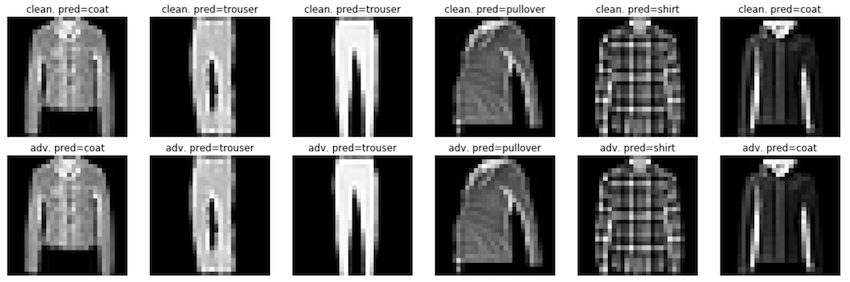
$$PGD\ with\ epsilon = 0.02$$
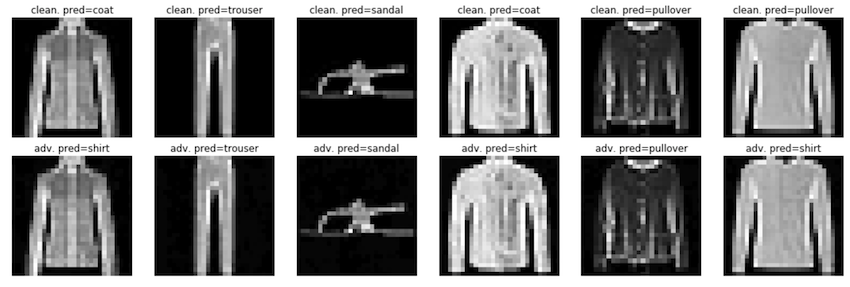
$$PGD\ with\ epsilon = 0.1$$
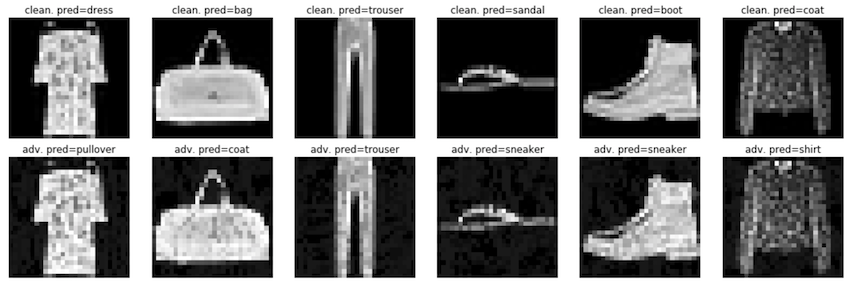
$$PGD\ with\ epsilon = 0.3$$
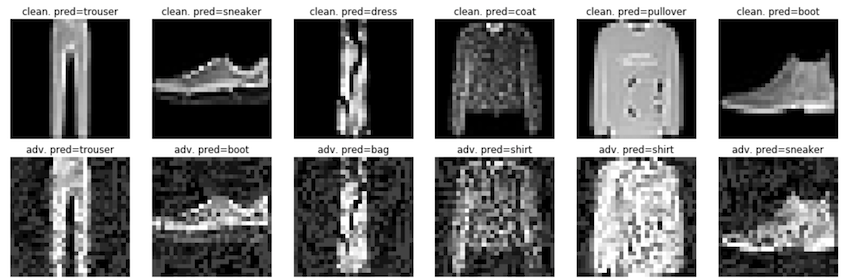

**(c)** 

(8 pts) Implement the Fast Gradient Sign Method (FGSM) attack in the *attacks.py* file. (Hint: treat the FGSM function as a wrapper around the PGD function). Then, plot some perturbed samples using the same $\epsilon$ levels from the previous question and comment on the perceptibility of the FGSM noise. Does the FGSM and PGD noise appear visually similar?

> The levels of $\epsilon$ are about the same for when noise becomes perceptible for both FGSM and PGD. Noise for FGSM and PGD appear to be quite similar, even at high values of $\epsilon$. The only difference I notice is that the whites become much brighter for epsilon at a value of 0.3 for FGSM compared to the PGD at an epsilon of 0.3. 

$$FGSM\ with\ epsilon = 0$$
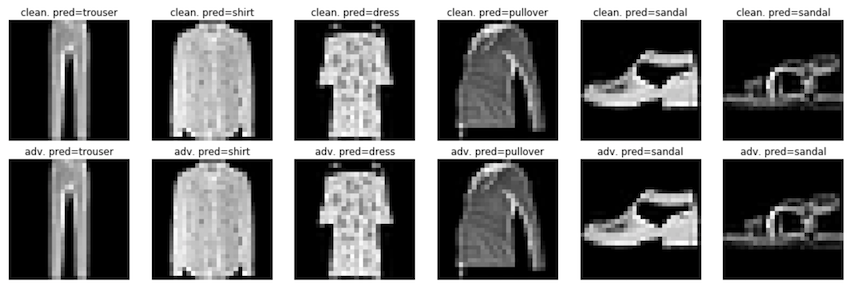
$$FGSM\ with\ epsilon = 0.02$$
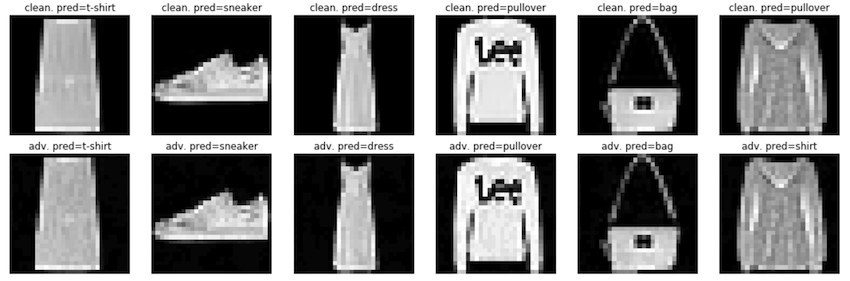
$$FGSM\ with\ epsilon = 0.1$$
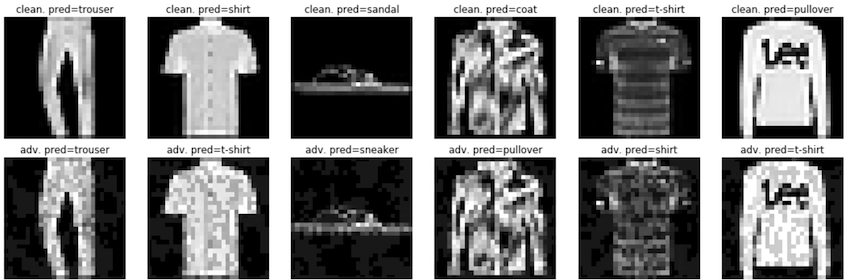
$$FGSM\ with\ epsilon = 0.3$$
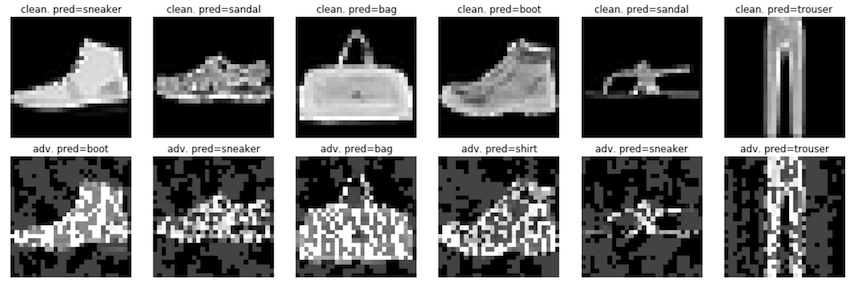

# Lab 2: Measuring Attack Success Rate (40 pts)

In this section, you will measure the effectiveness of your PGD and FGSM attacks. Remember, the goal of an adversarial attacker is to perturb the input data such that the classifier outputs a wrong prediction, while the noise is minimally perceptible to a human observer. All code for this set of questions will be in the “Test Attacks” section of HWK5_main.ipynb and in the accompanying attacks.py file. Please include all of your results, figures and observations into your PDF report.

**(a)**

(5 pts) Briefly describe the difference between a whitebox and blackbox adversarial attack. Also, what is it called when we generate attacks on one model and input them into another model that has been trained on the same dataset?

> In a whitebox attack, the attacker has full access to the target model and therefore has knowledge of the DNN architecture and weights. In a blackbox attack, the attacker does not have knowledge of the target model; the attacker only has query access to the target model. Transfer attacks are where we train on a proxy DNN model using the same dataset as used in the target model and generate attacks on this model to apply to the target model.

**(b)** 

(10 pts) Whitebox Attack - Using your pre-trained “NetA” as the whitebox model, measure the whitebox classifier’s accuracy versus attack epsilon for both the FGSM and PGD attacks. Test at least eleven ε values across the range [0, 0.1] (e.g., np.linspace(0,0.1,11)) and plot the accuracy vs epsilon curve. For the PGD attacks, use perturb_iters = 10 and α = 1.85*(ε/perturb_iters). Comment on the difference between the attacks. Do either of the attacks induce the equivalent of “random guessing” accuracy? If so, which attack and at what ε value? (Note: in the code, problem (b) and (c) can be run simultaneously)

> As shown on the plots below, the PGD attack is much more successful at lowering the whitebox classifier's accuracy for every value of $\epsilon$. PGD attack whitebox accuracy decreases much faster than when using a FGSM attack and it appears that both of the accuracies begin leveling off as $\epsilon$ increases.  PGD at an $\epsilon$ value of 0.1 produces the equivalent of random guessing accuracy which would be .1 since there are 10 classes/labels in this dataset. PGD with an $\epsilon$ of 0.1 actually goes below random guessing accuracy achieving an accuracy of 0.0728. FGSM attack appears to level off at an accuracy of 0.3. 

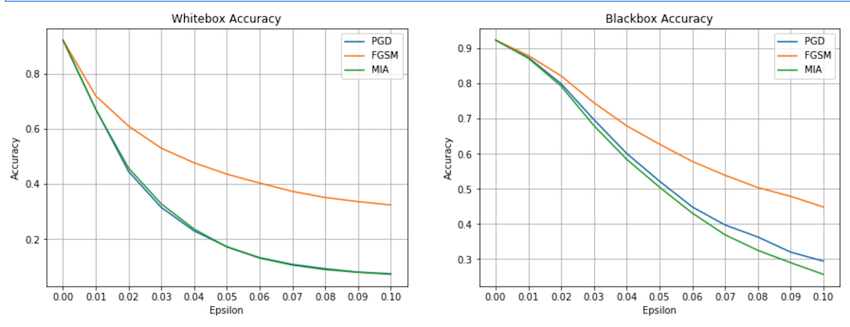

**(c)**

(10 pts) *Blackbox Attack* Using the pre-trained “NetA” as the whitebox model and the pre-trained “NetB” as the blackbox model, measure the ability of adversarial examples generated on the whitebox model to transfer to the blackbox model. Specifically, measure the blackbox classifier’s accuracy versus attack epsilon for both the FGSM and PGD attacks. Use the same ε values across the range [0, 0.1] and plot the blackbox model’s accuracy vs epsilon curve. For the PGD attacks, use perturb_iters = 10 and α = 1.85*(ε/perturb_iters). Comment on the difference between the blackbox attacks. Do either of the attacks induce the equivalent of “random guessing” accuracy? If so, which attack and at what ε value? (Note: in the code, problem (b) and (c) can be run simultaneously)

> As shown on the plots above, the PGD attack is much more sucessful at lowering the blackbox classifier's accuracy for every value of $\epsilon$. Both attacks decrease the accuracy slower than what was previously seen in the whitebox model which makes sense considering the attack was made using the whitebox and that the blackbox has a different model architecture. However, the slope of the loss as $\epsilon$ increases suggests that increasing $\epsilon$ could lead to the accuracies almost as low as what was seen in the whitebox attack. Neither attack induced the equivalent of random guessing accuracy although perhaps with a higher $\epsilon$ we may see this for the PGD attack. 

**(d)** 

(5 pts) Comment on the difference between the attack success rate curves for the whitebox and blackbox attacks. Which is the more powerful attack and why? Does this make sense? Also, consider the epsilon level you found to be the “perceptibility threshold” in Lab 1.b. What is the attack success rate at this level and do you find the result somewhat concerning?

> Based on the attack success curves for the whitebox and blackbox attacks, PGD appears to be more powerful. This makes sense for two reasons. FGSM is not iterative and simply uses a single instance of gradient ascent to maximize the loss while PGD uses iteration and therefore may find a more optimal path towards a decision boundary which would increase the loss more. This means that with a lower epsilon PGD is able to increase the loss more than FGSM. The second reason is that PGD starts from a random point near the data sample. If the datapoint is near a local minimum in the n-dimensional gradient space, this may cause FGSM to contradict the direction of the nearest decision boundary. Since PGD starts from that random point, it may start past or be able to find a route around the local minimum towards the nearest decision boundary. 

> Looking at the epsilon I found the "perceptibility threshold" to be at in Lab1.b ($\epsilon$ = 0.02), for the whitebox attack and blackbox attack, the accuracy observed is around 0.4 and 0.8, respectively. This is concerning because if the attacker knows the model architecture and weights, by using a low epsilon, which barely changes the images by a perceptible amount, the attacker is able to severly lower the accuracy of the model. For the whitebox attack, where the attacker uses a model the similar to the target model to produce the attack, we see that the accuracy is still lowered by a fair amount. This is concerning because these perturbations are barely noticable to the human eye but produce such a large drop in accuracy in both types of models. For researchers who must look through tons of images to make a dataset, a small perturbation like this might be overlooked.

**(e)** 

(10 pts) Implement the “Momentum Iterative FGSM” (MI-FGSM) from Algorithm 1 of https://arxiv.org/pdf/1710.06081.pdf in the attacks.py file. Note, this should be very similar to your PGD attack (so use copy-paste), with the most noticeable difference being the accumulation of a momentum term throughout the attack iterations. Test the effectiveness of this method as a blackbox attack and compare to the results obtained in part (c) across the same ε values, with perturb_iters = 10 and α = 1.85 * (ε/perturb_iters). Does momentum help? If so, give an intuitive explanation as to why. (Note: MI-FGSM involves a normalization of the gradient, but since these attack functions take a batch of inputs, the norm must be computed separately for each element of the batch)

> Plot is located in question 2b and MI-FGSM is labeled MIA. Momentum does help for black box attacks. By adding in the momentum term for our attacks, this allows our attacks to escape from poor local maxima during the iterative gradient ascent updates. This results in more transferable adversarial examples and thus a higher success rate for black box attacks. 

# Lab 3: Adversarial Training (40 pts + 10 Bonus)

In this section, you will implement a basic defense called adversarial training (AT). As the name suggests, this involves training the model against adversarial examples. Specifically, we will be using the AT described in https://arxiv.org/pdf/1706.06083.pdf, which formulates the training objective as


min E maxL(f(x+δ;θ),y) θ (x,y)∼D δ∈S

Importantly, the inner maximizer specifies that all of the training data should be adversarially perturbed before updating the network parameters. All code for this set of questions will be in the HWK5_main.ipynb file. Please include all of your results, figures and observations into your PDF report.

**(a)**

(5 pts) Using the given “Model Training” code, adversarially train a “NetA” model using a FGSM attack with ε = 0.1, and save the model checkpoint as “netA_advtrain_fgsm0p1.pt”. What is the final training accuracy of this model on the clean test data? Is the accuracy less than the standard trained model?

> Using NetA and training with a FGSM attack with a $\epsilon$ of 0.1, I was able to achieve a training accuracy of approximately 0.963 and a test accuracy of approximately 0.7113. When NetA was trained with the original unperturbed samples, it was able to achieve a test accuracy of 0.9213. Therefore, the model trained with against FGSM adversarial images did have less accuracy than the standard trained model. 


**(b)**

(5pts) Using the given “Model Training” code, adversarially train a “NetA” model using a PGD attack with ε = 0.1, perturb_iters = 4, α = 1.85 * (ε/perturb_iters), and save the model checkpoint as “netA_advtrain_pgd0p1.pt”. What is the final training accuracy of this model on the clean test data? Is the accuracy less than the standard trained model? Are there any noticeable differences in the training convergence between the FGSM-based and PGD-based AT procedures?

> NetA trained with PGD perturbed images had a final training accuracy of 0.8240, and a test accuracy of 0.8735. This accuracy is indeed than the standard trained model. FGSM-based training appeared to lead to overfitting while PGD-based training did not as its test accuracy was continuously improving. Test accuracy for the FGSM-based training bounced around a good amount and ended with a much lower test accuracy than what was seen for the PGD-trained model. The PGD test accuracy kept improving upon every epoch indicating that it was not overfitting.

**(c)**

(15 pts) For the model adversarially trained with FGSM (“netA_advtrain_fgsm0p1.pt”), compute the accuracy versus attack epsilon curves against both the FGSM and PGD attacks (as whitebox methods only). Use ε = [0.0, 0.02, 0.04, . . . , 0.12]. Is the model robust to both types of attack? If not, explain and analyze why one attack might be better than another. (Note: you can run this code in the “Test Robust Models” cell of the HWK5_main.ipynb notebook).

> When adversarially trained with FGSM, we see that accuracy for a FGSM attack actually increases as epsilon increases up to a value of 0.1 for epsilon. When a PGD attack is employed the accuracy drops as the epsilon increases. Under the PGD attack we actually see the accuracy decrease towards .1 which would be random guessing. The model is not robust to both types of attacks. PGD can be seen as a more advanced version of FGSM. It has the same concept of FGSM except that it applies its gradient ascent iteratively and that it has a random starting point within a range of $-\epsilon$ to $\epsilon$. Therefore since PGD is essentially a more advanced version of FGSM, it is a stronger attack. Therefore a model trained to prevent FGSM attacks from working will likely not work in preventing PGD attacks. 

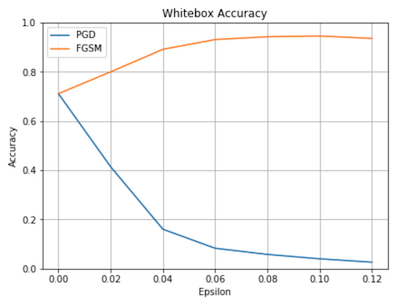

**(d)**

(15 pts) For the model adversarially trained with PGD (“netA_advtrain_pgd0p1.pt”), compute the accuracy versus attack epsilon curves against both the FGSM and PGD attacks (as whitebox methods only). Use ε = [0.0, 0.02, 0.04, . . . , 0.12], perturb_iters = 10, α = 1.85*(ε/perturb_iters). Is the model robust to both types of attack? Explain why or why not and analyze. Can you conclude that one adversarial training method is better than the other? If so, provide an intuitive explanation as to why (this paper may help explain: https://arxiv.org/pdf/2001.03994.pdf). (Note: you can run this code in the “Test Robust Models” cell of the HWK5_main.ipynb notebook).

> When adversarially trained with PGD we see that as epsilon increases, accuracy decreases when using either a PGD or FGSM attack. This model is robust to both kinds of attacks. As explained in the last question, since PGD is essentially a more advanced version of FGSM, training on PGD data should allow the model to reduce the effectiveness of both PGD and FGSM attacks. PGD with random starts is shown to represent a universal first-order adversary to training on this should prevent all first-order attacks such as FGSM. 

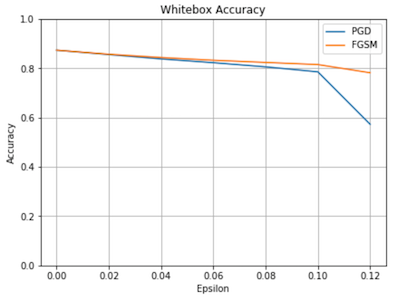

**(e)**

(Bonus 5 pts) Using PGD-based AT, train a few more models with different training ε values. Is there a trade-off between clean data accuracy and training ε? Is there a trade-off between robustness and training ε? What happens when the testing PGD’s ε is larger than the ε used for training? In the report, provide answers to all of these questions along with evidence (e.g., plots and/or tables) to substantiate your claims. 

> In the plot shown below models were trained with epsilon values of 0.15 and 0.2. PGD attacks were used against these models with an epsilon value ranging from 0 to 0.25. As can be seen in the plots, when a PGD attack is used with an epsilon greater than the epsilon value used to train the model, performance of the model rapidly declines and eventually hits an accuracy akin to random guessing. Up to the epsilon value used the train the model, accuracy does not diminish by a large amount. However, as soon as the epsilon value used in the attack is greater than what was used to train the model, we see a rapid decline in test accuracy. There is a tradeoff between models trained with a higher versus lower epsilon as the model trained with a lower epsilon actually has a higher accuracy on clean test data.

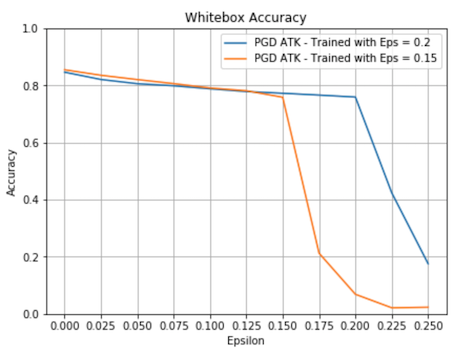

**(f)**

(Bonus 5 pts) Plot the saliency maps for a few samples from the FashionMNIST test set as measured on both the standard (non-AT) and PGD-AT models. Do you notice any difference in saliency? What does this difference tell us about the representation that has been learned? (Hint: plotting the gradient w.r.t. the data is often considered a version of saliency, see https: //arxiv.org/pdf/1706.03825.pdf)